In [15]:
pip install -U numpy==1.19.2
#版本不兼容

SyntaxError: invalid syntax (Temp/ipykernel_9556/3994638311.py, line 1)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.164402   0.330781   0.210971   0.832742   0.515376   0.784759   
2   0.161169   0.330267   0.209265   0.852153   0.508083   0.776487   
3   0.157595   0.329632   0.230774   0.823618   0.500790   0.764546   
4   0.155579   0.328998   0.250395   0.808371   0.493498   0.752605   
5   0.150821   0.328363   0.202601   0.761948   0.486205   0.745326   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.822684   0.806942  0.161169  
2   0.817629   0.806942  0.157595  
3   0.782909   0.768061  0.155579  
4   0.773560   0.768061  0.150821  
5   0.743634   0.724544  0.147463  
(1000, 1, 8) (1000,) (523, 1, 8) (523,)
Epoch 1/50
14/14 - 1s - loss: 0.1971 - val_loss: 0.1718
Epoch 2/50
14/14 - 0s - loss: 0.0936 - val_loss: 0.1401
Epoch 3/50
14/14 - 0s - loss: 0.0703 - val_loss: 0.1383
Epoch 4/50
14/14 - 0s - loss: 0.0664 - val_loss: 0.1377
Epoch 5/50
14/14 - 0s - loss: 0.0681 - val_loss: 0.1345
Epoch 6/50
14/14 - 0s - loss: 0.0645 

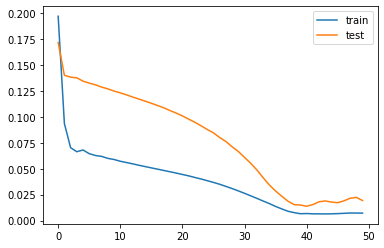

Test RMSE: 0.024


In [ ]:
# 加载数据集
from pandas import read_csv
from matplotlib import pyplot
import numpy as np
import sklearn
from math import sqrt
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

a=np.loadtxt('Btrain_input.txt',dtype=np.float32)
b=np.loadtxt('Btrain_output.txt',dtype=np.float32)
b = b[:,np.newaxis]
values=np.concatenate((b,a),axis=1)

# 将序列转换成监督学习问题
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 归一化特征
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# 构建监督学习问题
reframed = series_to_supervised(scaled, 1, 1)
# 丢弃我们不想预测的列
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
# 把数据分为训练集和测试集
values = reframed.values
n_train_hours = 1000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# 把数据分为输入和输出
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# 把输入重塑成3D格式 [样例， 时间步, 特征]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# 设计网络
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# 拟合网络
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# 绘制历史数据
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# 作出预测
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# 反向缩放预测值
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# 反向转换实际值比例
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# 计算RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

52
(800, 8)
(799, 16)
(583, 8) (799, 8)
(1000, 7) (1000,) (583, 7) (583,) (799, 7) (799,)
(1000, 1, 7) (1000,) (583, 1, 7) (583,) (799, 1, 7) (799,)
Epoch 1/50
14/14 - 0s - loss: 0.1693 - val_loss: 0.1380
Epoch 2/50
14/14 - 0s - loss: 0.0841 - val_loss: 0.1381
Epoch 3/50
14/14 - 0s - loss: 0.0656 - val_loss: 0.1298
Epoch 4/50
14/14 - 0s - loss: 0.0701 - val_loss: 0.1300
Epoch 5/50
14/14 - 0s - loss: 0.0694 - val_loss: 0.1308
Epoch 6/50
14/14 - 0s - loss: 0.0676 - val_loss: 0.1304
Epoch 7/50
14/14 - 0s - loss: 0.0683 - val_loss: 0.1304
Epoch 8/50
14/14 - 0s - loss: 0.0681 - val_loss: 0.1304
Epoch 9/50
14/14 - 0s - loss: 0.0682 - val_loss: 0.1303
Epoch 10/50
14/14 - 0s - loss: 0.0682 - val_loss: 0.1304
Epoch 11/50
14/14 - 0s - loss: 0.0682 - val_loss: 0.1304
Epoch 12/50
14/14 - 0s - loss: 0.0682 - val_loss: 0.1304
Epoch 13/50
14/14 - 0s - loss: 0.0682 - val_loss: 0.1304
Epoch 14/50
14/14 - 0s - loss: 0.0682 - val_loss: 0.1304
Epoch 15/50
14/14 - 0s - loss: 0.0682 - val_loss: 0.1304
Epoch

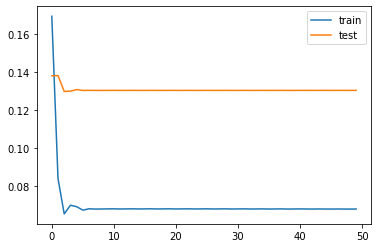

(799, 1)
(799, 7)
(799, 8)


D:\Programs\anaconda\lib\site-packages\xlsxwriter\workbook.py:336: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [2]:
# 加载数据集
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
import numpy as np
import sklearn
from math import sqrt
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

a=np.loadtxt('train_input.txt',dtype=np.float32)
b=np.loadtxt('Btrain_output.txt',dtype=np.float32)
c=np.loadtxt('Btest_input.txt',dtype=np.float32)
d=np.ones([798,1], dtype = int)
b = b[:,np.newaxis]
k=0
for i in range(len(c)):   
    for j in range(len(c[i])):
        if np.isnan(c[i][j]):
            #print(i,j)
            c[i][j]=0
            k=k+1
print(k)
#将训练集最后一行作为测试集第一行
values=np.concatenate((b,a),axis=1)
g = a[1595]
g = g[np.newaxis,:]
f = b[1595]
f = f[np.newaxis,:]
e=np.concatenate((g,c),axis=0)
f=np.concatenate((f,d),axis=0)
h = c[797]
h = h[np.newaxis,:]
i = d[797]
i = i[np.newaxis,:]
e=np.concatenate((e,h),axis=0)
f=np.concatenate((f,i),axis=0)
values2=np.concatenate((f,e),axis=1)
print(values2.shape)
# 将序列转换成监督学习问题
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 归一化特征
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled2 = scaler.fit_transform(values2)
# 构建监督学习问题
reframed = series_to_supervised(scaled, 1, 1)
reframed2 = series_to_supervised(scaled2, 1, 1)
print(reframed2.shape)
# 丢弃我们不想预测的列
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#print(reframed.head())
reframed2.drop(reframed2.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#print(reframed2.head())
# 把数据分为训练集和测试集
values = reframed.values
n_train_hours = 1000
train = values[:n_train_hours, 1:]
test = values[n_train_hours:, 1:]
test2 = reframed2.values[:,1:]
print(test.shape,test2.shape)
# 把数据分为输入和输出
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
test_X2, test_y2 = test2[:, :-1], test2[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape,test_X2.shape,test_y2.shape)
# 把输入重塑成3D格式 [样例， 时间步, 特征]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
test_X2 = test_X2.reshape((test_X2.shape[0], 1, test_X2.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape,test_X2.shape,test_y2.shape)
# 设计网络
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# 拟合网络
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# 绘制历史数据
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# 作出预测
yhat = model.predict(test_X2)
print(yhat.shape)
test_X2 = test_X2.reshape((test_X2.shape[0], test_X2.shape[2]))
print(test_X2.shape)
# 反向缩放预测值
inv_yhat = concatenate((yhat, test_X2[:,:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:]
print(inv_yhat.shape)
data = pd.DataFrame(inv_yhat)
writer = pd.ExcelWriter('TEST.xlsx')
data.to_excel(writer, 'page_1', float_format='%.5f')		# ‘page_1’是写入excel的sheet名
writer.save()
writer.close()